In [26]:
import pandas as pd
from pathlib import Path
from PIL import Image
import numpy as np

# Import PyTorch core and utilities for deep learning
import torch
import torch.nn.functional as F  # Functional API for non-parametric operations
# Import PyTorch utilities for data loading and transformations
from torchvision.transforms.v2 import Compose, ToImage, Normalize, ToPILImage, Resize, ToDtype
# Import dataset handling and learning rate schedulers
from torchvision.datasets import ImageFolder

# Import visualization and web utilities
import matplotlib.pyplot as plt
import seaborn as sns





# Set matplotlib style for better visuals
plt.style.use('fivethirtyeight')

# Import Data folder

dataset_iracing/

 - reta
 - freada_apex
 - saida_curva
 - freada

In [5]:
# Save normalization values as normalize2 (as tensors)
normalizer = Normalize(
    mean=torch.tensor([0.2628, 0.2793, 0.2886]),
    std=torch.tensor([0.2412, 0.2640, 0.2837]),
    inplace=False
)
normalizer  

Normalize(mean=[tensor(0.2628), tensor(0.2793), tensor(0.2886)], std=[tensor(0.2412), tensor(0.2640), tensor(0.2837)], inplace=False)

In [7]:
# Define a pipeline of image transformations:
# 1) Resize each image to 28×28 pixels
# 2) Ensure the output is a PIL/torchvision image (dropping any alpha channel)
# 3) Cast pixels to float32 and scale from [0–255] to [0.0–1.0]
# 4) Apply the user-defined normalization (e.g., mean/std normalization)
composer = Compose([
    Resize([28,28]),                         # Resize to 28×28
    ToImage(),                          # Convert to PIL Image in RGB
    ToDtype(torch.float32, scale=True), # Cast to float32 and normalize to [0,1]
    normalizer                          # Apply custom normalization transform
])

# Instantiate training and validation datasets from folders:
# - 'train_dataset_iracing' contains subfolders per class for training
# - 'test_dataset_iracing' likewise for validation
train_data = ImageFolder(root='train_dataset_iracing', transform=composer)
val_data   = ImageFolder(root='test_dataset_iracing', transform=composer)


In [24]:
# --- Configuration for both sets ---
TRAIN_DIR = Path("./train_dataset_iracing")
VAL_DIR = Path("./test_dataset_iracing") # Assuming this is your validation set path

def analyze_dataset_path(dataset_path: Path, dataset_type: str):
    """
    Analyzes a given dataset path (train or val) and returns a DataFrame.
    """
    if not dataset_path.exists():
        print(f"Warning: {dataset_type.capitalize()} directory not found at '{dataset_path}'. Skipping.")
        return pd.DataFrame() # Return empty DataFrame if path doesn't exist

    print(f"\nLoading {dataset_type} dataset from: {dataset_path}")
    dataset = ImageFolder(root=dataset_path)
    print(f"Found {len(dataset)} images in {len(dataset.classes)} classes for {dataset_type} set.")
    
    image_data = []
    for path, label_idx in dataset.imgs:
        try:
            with Image.open(path) as img:
                width, height = img.size
                image_data.append({
                    "path": path,
                    "class": dataset.classes[label_idx],
                    "width": width,
                    "height": height,
                    "split": dataset_type # Add a column to identify the split (train/val)
                })
        except Exception as e:
            print(f"Could not read image {path}: {e}")
            
    return pd.DataFrame(image_data)

# --- Process both datasets ---
train_df = analyze_dataset_path(TRAIN_DIR, "train")
val_df = analyze_dataset_path(VAL_DIR, "validation")

# --- Combine into a single DataFrame for overall analysis ---
combined_df = pd.concat([train_df, val_df], ignore_index=True)

print("\n--- Analysis Complete ---")
if not combined_df.empty:
    print("Combined Dataset Metadata (first 5 rows):")
    display(combined_df.head())
    
    print("\nTotal images per split:")
    print(combined_df['split'].value_counts())
else:
    print("No data was loaded. Please check your directory paths.")



Loading train dataset from: train_dataset_iracing
Found 7926 images in 4 classes for train set.

Loading validation dataset from: test_dataset_iracing
Found 1413 images in 4 classes for validation set.

Loading validation dataset from: test_dataset_iracing
Found 1413 images in 4 classes for validation set.

--- Analysis Complete ---
Combined Dataset Metadata (first 5 rows):

--- Analysis Complete ---
Combined Dataset Metadata (first 5 rows):


,path,class,width,height,split
0,train_dataset_iracing\curva_apex\curva (1).jpg,curva_apex,3840,2160,train
1,train_dataset_iracing\curva_apex\curva (10).jpg,curva_apex,3840,2160,train
2,train_dataset_iracing\curva_apex\curva (100).jpg,curva_apex,3840,2160,train
3,train_dataset_iracing\curva_apex\curva (1000).jpg,curva_apex,3840,2160,train
4,train_dataset_iracing\curva_apex\curva (1001).jpg,curva_apex,3840,2160,train



Total images per split:
split
train         7926
validation    1413
Name: count, dtype: int64


C:\Users\PC\AppData\Local\Temp\ipykernel_21308\2287070652.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


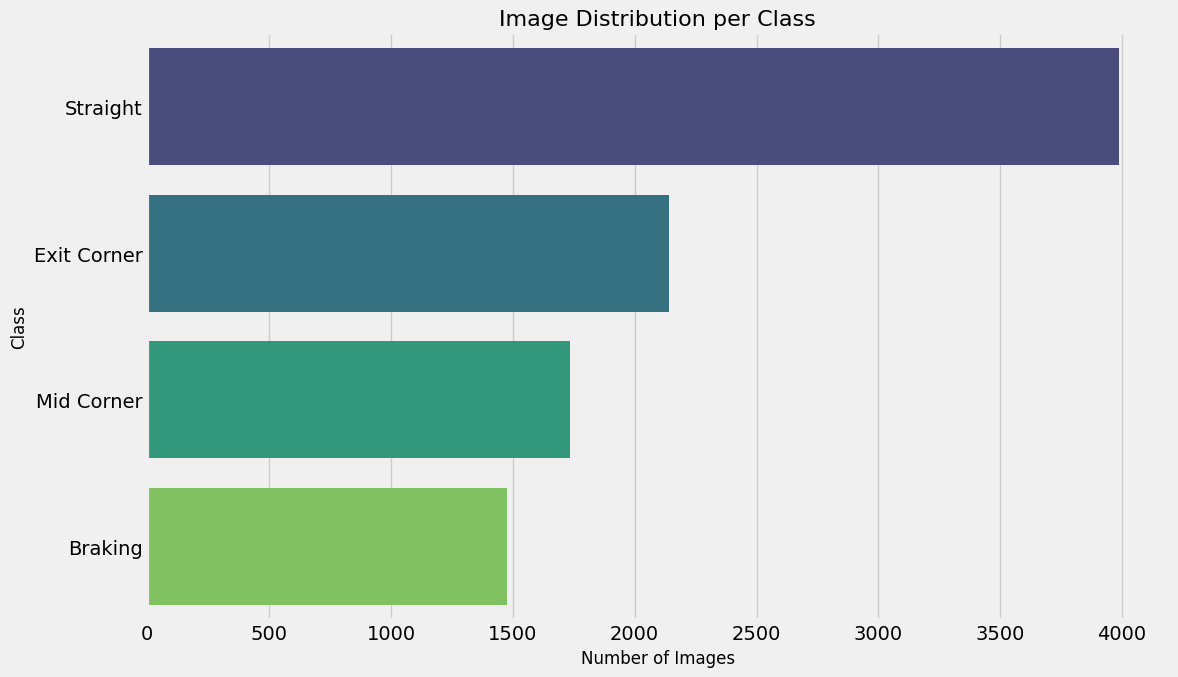

Image count per class:
display_name
Straight       3989
Exit Corner    2141
Mid Corner     1733
Braking        1476
Name: count, dtype: int64


In [20]:
#
# Cell 3 (Updated): Plot Class Distribution with Custom Names
#

# 1. Define a mapping from folder names to desired display names
# Make sure these folder names exactly match the ones in your dataset
class_name_mapping = {
    'reta': 'Straight',
    'saida_curva': 'Exit Corner',
    'curva_apex': 'Mid Corner',
    'freada': 'Braking'
}

# 2. Create a temporary column with the new display names for plotting
# We use .get(x, x) to keep the original name if a mapping isn't found
plot_df = combined_df.copy()
plot_df['display_name'] = plot_df['class'].apply(lambda x: class_name_mapping.get(x, x))

# 3. Plot using the new 'display_name' column
plt.figure(figsize=(12, 7))
sns.countplot(
    y=plot_df['display_name'],
    order=plot_df['display_name'].value_counts().index, # Order bars by count
    palette="viridis"
)
plt.title('Image Distribution per Class', fontsize=16)
plt.xlabel('Number of Images', fontsize=12)
plt.ylabel('Class', fontsize=12)
plt.tight_layout()
plt.show()

# 4. Print the exact counts using the new names
print("Image count per class:")
print(plot_df['display_name'].value_counts())

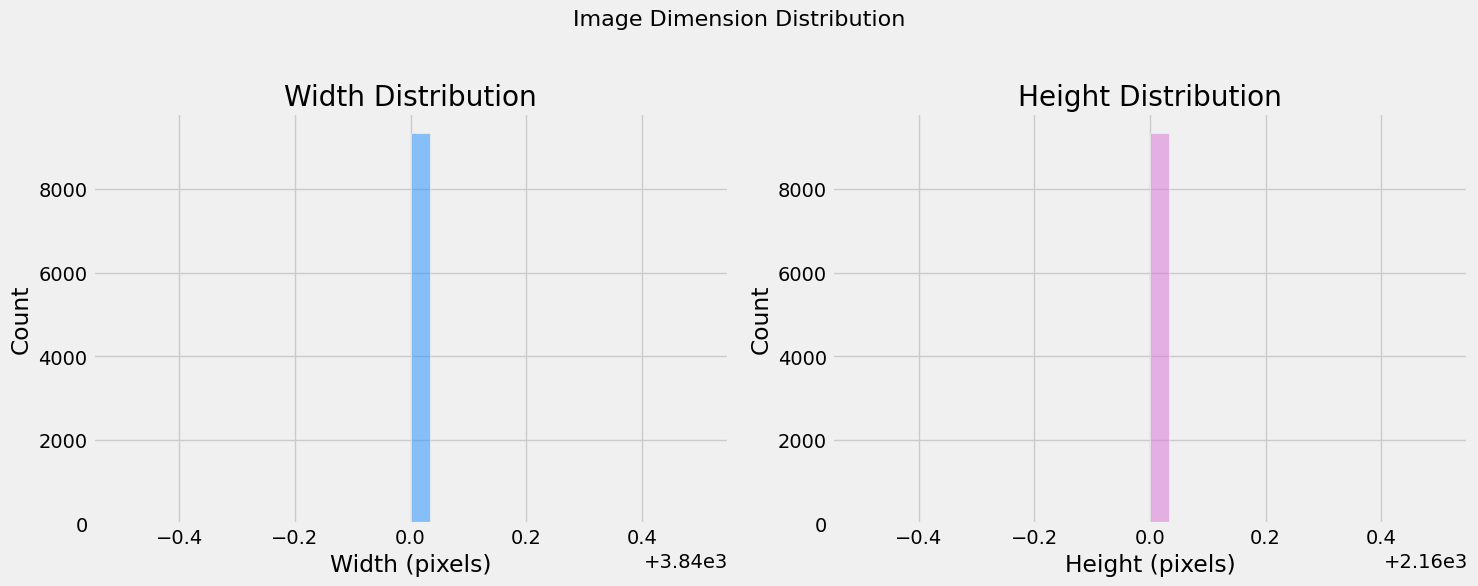

In [19]:
#
# Cell 4: Plot Image Dimension Distribution
#
plt.figure(figsize=(15, 6))
plt.suptitle('Image Dimension Distribution', fontsize=16)

# Width Distribution
plt.subplot(1, 2, 1)
sns.histplot(combined_df['width'], kde=True, bins=30, color="dodgerblue")
plt.title('Width Distribution')
plt.xlabel('Width (pixels)')

# Height Distribution
plt.subplot(1, 2, 2)
sns.histplot(combined_df['height'], kde=True, bins=30, color="orchid")
plt.title('Height Distribution')
plt.xlabel('Height (pixels)')

plt.tight_layout(rect=[0, 0, 1, 0.96])
# To save the figure, uncomment the line below
# plt.savefig(OUTPUT_DIR / "dimension_distribution.png")
plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_21308\1681135348.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(class_names, rotation=45)
C:\Users\PC\AppData\Local\Temp\ipykernel_21308\1681135348.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(class_names, rotation=45)


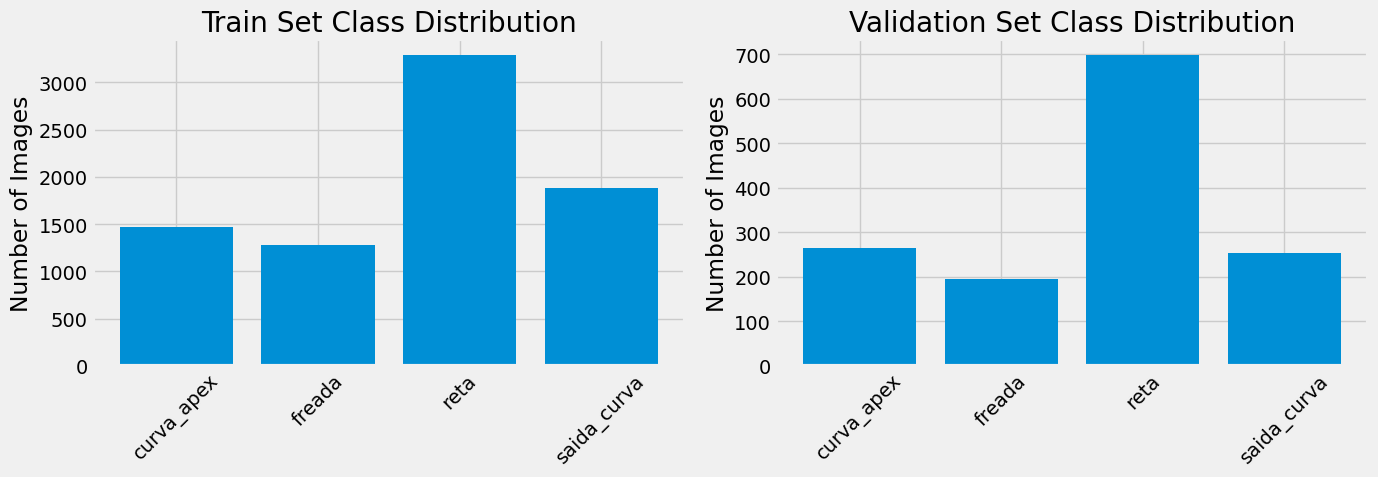

In [9]:
# Exploratory Data Analysis (EDA) for train_data and val_data

# 1. Number of images per class in train and validation sets
train_class_counts = pd.Series([label for _, label in train_data]).value_counts().sort_index()
val_class_counts = pd.Series([label for _, label in val_data]).value_counts().sort_index()

# 2. Map class indices to class names
class_names = train_data.classes

# 3. Display class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].bar(class_names, train_class_counts)
axes[0].set_title('Train Set Class Distribution')
axes[0].set_ylabel('Number of Images')
axes[0].set_xticklabels(class_names, rotation=45)

axes[1].bar(class_names, val_class_counts)
axes[1].set_title('Validation Set Class Distribution')
axes[1].set_ylabel('Number of Images')
axes[1].set_xticklabels(class_names, rotation=45)

plt.tight_layout()
plt.show()



In [21]:
# Calculate the percentage of images per class in train and validation sets

# Get class names in order
class_labels = class_names

# Get counts per class for train and val (already sorted by class index)
train_counts = train_class_counts.values
val_counts = val_class_counts.values

# Calculate percentages
train_percentages = 100 * train_counts / train_counts.sum()
val_percentages = 100 * val_counts / val_counts.sum()

# Create a DataFrame for easy viewing
balance_df = pd.DataFrame({
    'Class': [class_name_mapping.get(c, c) for c in class_labels],
    'Train Count': train_counts,
    'Train %': train_percentages,
    'Val Count': val_counts,
    'Val %': val_percentages
})

print(balance_df)

         Class  Train Count    Train %  Val Count      Val %
0   Mid Corner         1469  18.533939        264  18.683652
1      Braking         1280  16.149382        196  13.871196
2     Straight         3290  41.508958        699  49.469214
3  Exit Corner         1887  23.807721        254  17.975938


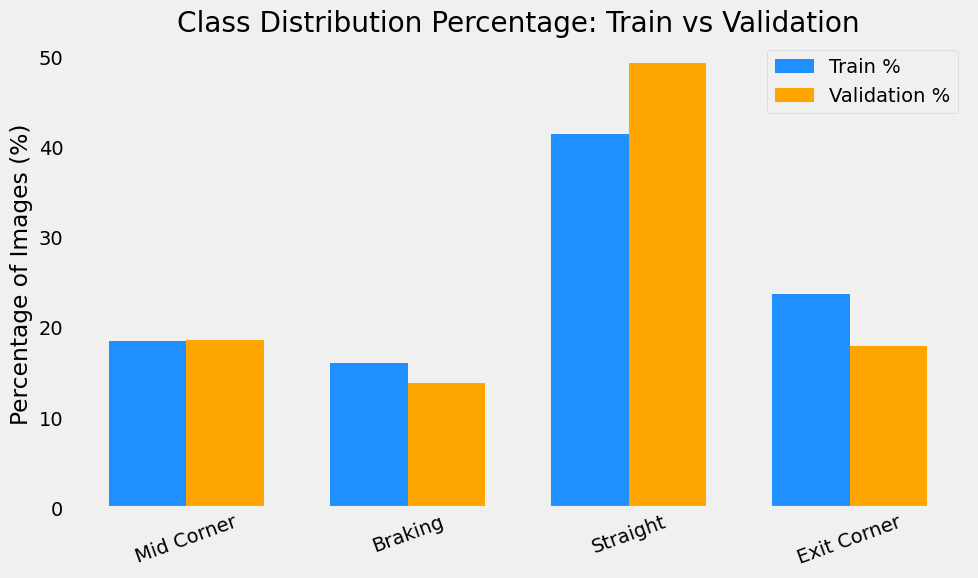

In [28]:
# Plot grouped bar graph for percentage of images per class in train and validation sets
plt.figure(figsize=(10, 6))
bar_width = 0.35
x = np.arange(len(balance_df['Class']))
plt.bar(x - bar_width/2, balance_df['Train %'], bar_width, label='Train %', color='dodgerblue')
plt.bar(x + bar_width/2, balance_df['Val %'], bar_width, label='Validation %', color='orange')
plt.xticks(x, balance_df['Class'], rotation=20)
plt.ylabel('Percentage of Images (%)')
plt.title('Class Distribution Percentage: Train vs Validation')
# Turn off grid for the previous plot (if not already set)
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()